In [1]:
!date

Sun May 18 07:47:37 PM EDT 2025


In [2]:
pwd

'/projects/sccn/andromeda1/aglinska/BC-ABCD-denoise/Code'

In [3]:
import os
import numpy as np
import pandas as pd
import ants
from matplotlib import pyplot as plt
import pickle
from tqdm import tqdm

In [4]:
indir = '../Data/StudyForrest/ensembles_last_CVAE/'
folders = [f for f in os.listdir(indir)]
folders.sort()
folders

['.ipynb_checkpoints',
 'BrainIAK-CVAE-0',
 'BrainIAK-CVAE-1',
 'DeNN-forrest-v1',
 'DeepCor-ABCD-v1',
 'DeepCor-ABCD-v2',
 'DeepCor-ABCD-v3',
 'DeepCor-ABCD-v4',
 'DeepCor-ABCD-v5',
 'DeepCor-Forrest-ablations-00-baseline',
 'DeepCor-Forrest-ablations-01-nosummation',
 'DeepCor-Forrest-ablations-02-noAdvRemoval',
 'DeepCor-Forrest-ablations-03-noNCC',
 'DeepCor-Forrest-ablations-03-noTC',
 'DeepCor-Forrest-ablations-04-noCoords',
 'DeepCor-Forrest-ablations-06-noAll',
 'DeepCor-Forrest-ablations-06-noAll-v2',
 'DeepCor-Forrest-face-big-16',
 'DeepCor-Forrest-face-long',
 'DeepCor-Forrest-face-v1',
 'DeepCor-Forrest-face-v2',
 'DeepCor-Forrest-face-v3-pshort',
 'DeepCor-Forrest-face-v4',
 'DeepCor-Forrest-face-v5',
 'YuOrig-00-DataloaderFix',
 'YuOrig-00-orig',
 'fixed-seed-00-YuOrig-00-DataloaderFix',
 'fixed-seed-00-baseline-00',
 'slurm_files',
 'test',
 'test-lin']

In [7]:
analysis_name = 'fixed-seed-00-YuOrig-00-DataloaderFix'
#analysis_name = 'DeepCor-Forrest-ablations-00-baseline'

In [8]:
fn_temp = 'signal_S{s}_R{r}_avg.nii.gz'

Done:100.00%


Text(0.5, 0, 'Subject')

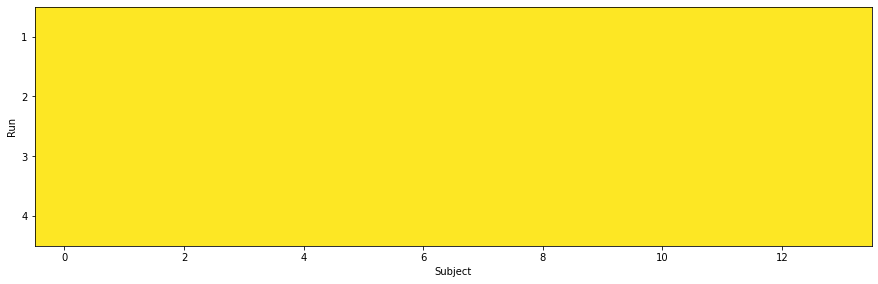

In [9]:
done_check = np.array([[os.path.exists(os.path.join(indir,analysis_name,fn_temp.format(s=s,r=r))) for r in [1,2,3,4]] for s in range(14)])
print(f'Done:{done_check.mean()*100:.2f}%')
plt.figure(figsize=(15,5))
plt.imshow(done_check.transpose(),vmin=0,vmax=1)
plt.yticks(np.arange(4),labels=[1,2,3,4])
plt.ylabel('Run')
plt.xlabel('Subject')

In [10]:
events_fn_temp = '../Data/StudyForrest/events/{sub}_ses-localizer_task-objectcategories_run-{r}_events.tsv'
def get_regs(events_fn):
    from nilearn.glm.first_level import make_first_level_design_matrix

    events = pd.read_csv(events_fn,delimiter='\t')

    t_r = 2.0 
    #n_scans = epi.shape[-1]
    n_scans = 156
    frame_times = (np.arange(n_scans) * t_r)

    X1 = make_first_level_design_matrix(frame_times,events,drift_model="polynomial",drift_order=3,hrf_model="SPM") #

    face_reg = X1[['face']].values.sum(axis=1)
    place_reg = X1[['body', 'house', 'object', 'scene', 'scramble']].values.sum(axis=1)
    
    return face_reg,place_reg

In [11]:
def get_contrast_val(Y,return_type='contrast'):
    from nilearn.glm.first_level import make_first_level_design_matrix

    events = pd.read_csv(events_fn_temp.format(sub=subs[s],r=r),delimiter='\t')

    t_r = 2.0 
    n_scans = 156  # the acquisition comprises 128 scans
    frame_times = (np.arange(n_scans) * t_r)

    X1 = make_first_level_design_matrix(frame_times,events,drift_model="polynomial",drift_order=3,hrf_model="SPM") #
    
    Y = (Y-Y.mean(axis=1)[:,np.newaxis])/Y.std(axis=1)[:,np.newaxis] # Z score values
    Y = Y.transpose()
    X = X1.values
    beta = np.linalg.inv(X.T @ X1) @ X1.T @ Y
    beta = beta.T
    beta = beta.values

    #['body', 'face', 'house', 'object', 'scene', 'scramble', 'drift_1','drift_2', 'drift_3', 'constant']
    contrast_vector = np.array([-1,5,-1,-1,-1,-1,0,0,0,0]) # Faces > Rest
    contrast_values = beta @ contrast_vector
    if return_type=='contrast':
        return contrast_values.mean()
    elif return_type=='betas':
        return beta.mean(axis=0)

In [12]:
def correlate_columns(arr1, arr2):
    """
    Computes the Pearson correlation between corresponding columns of two matrices.
    
    Parameters:
    arr1 (np.ndarray): First matrix of shape (370, 1000)
    arr2 (np.ndarray): Second matrix of shape (370, 1000)
    
    Returns:
    np.ndarray: 1D array of correlations for each column (size 1000)
    """
    # Ensure input arrays are numpy arrays
    arr1 = np.asarray(arr1)
    arr2 = np.asarray(arr2)
    
    # Subtract the mean of each column (normalize)
    arr1_centered = arr1 - np.mean(arr1, axis=0)
    arr2_centered = arr2 - np.mean(arr2, axis=0)
    
    # Compute the numerator (covariance)
    numerator = np.sum(arr1_centered * arr2_centered, axis=0)
    
    # Compute the denominator (product of standard deviations)
    denominator = np.sqrt(np.sum(arr1_centered**2, axis=0) * np.sum(arr2_centered**2, axis=0))
    
    # Compute the Pearson correlation for each column
    correlation = numerator / denominator
    
    return correlation

In [13]:
roi = ants.image_read('../Data/StudyForrest/fmriprep/mask_roi.nii')
roni = ants.image_read('../Data/StudyForrest/fmriprep/mask_roni.nii')

In [14]:
roi_dir = '../Data/StudyForrest/ROIs'
roi_fn_temp = 'rFFA_final_mask_{sub}_bin.nii.gz'

In [15]:
subs = ['sub-01','sub-02','sub-03','sub-04','sub-05','sub-09','sub-10','sub-14','sub-15','sub-16','sub-17','sub-18','sub-19','sub-20',]

In [16]:
face_reg,place_reg = get_regs(events_fn_temp.format(sub=subs[0],r=1))

In [17]:
faceMap = ants.image_read('../Misc/ffa_map_resampled_forrest.nii.gz')
faceMap_mask = faceMap.numpy()>5
faceMap_mask.sum()

953

In [18]:
res_corr2reg = np.zeros((14,4))
res_contrast = np.zeros((14,4))
res_specificity = np.zeros((14,4))

In [19]:
## DeepCor
for s in tqdm(range(14)):
    for r in [1,2,3,4]:
        subim = ants.image_read(os.path.join(indir,analysis_name,fn_temp.format(s=s,r=r)))
        subFFA = ants.image_read(os.path.join(roi_dir,roi_fn_temp.format(sub=subs[s])))
        valsFFA = subim.numpy()[subFFA.numpy()==1]
        valsFFA=valsFFA[valsFFA.std(axis=1)>1e-3,:]

        corr2reg = np.nanmean(correlate_columns(valsFFA.transpose(),np.array([face_reg for _ in range(valsFFA.shape[0])]).transpose()))
        contrastVal = get_contrast_val(valsFFA,return_type='contrast')

        arr1=subim.numpy()[(roi.numpy()==1) * (faceMap_mask==True)]
        arr2=subim.numpy()[(roi.numpy()==1) * (faceMap_mask==False)]

        arr1=arr1[arr1.std(axis=1)>1e-3]
        arr2=arr2[arr2.std(axis=1)>1e-3]
        r1=correlate_columns(arr1.transpose(),np.array([face_reg for _ in range(arr1.shape[0])]).transpose())
        r2=correlate_columns(arr2.transpose(),np.array([face_reg for _ in range(arr2.shape[0])]).transpose())
        specificity = r1.mean()-r2.mean()

        res_corr2reg[s,r-1] = corr2reg
        res_contrast[s,r-1] = contrastVal
        res_specificity[s,r-1] = specificity

100%|██████████| 14/14 [00:39<00:00,  2.79s/it]


In [21]:
print(f'res_corr2reg = {corr2reg.mean():.2f}')
print(f'res_contrast = {res_contrast.mean():.2f}')
print(f'Specificity = {res_specificity.mean():.2f}')

res_corr2reg = 0.18
res_contrast = 1.98
Specificity = 0.11


In [231]:
## RAW
res_corr2reg = np.zeros((14,4))
res_contrast = np.zeros((14,4))
res_specificity = np.zeros((14,4))

for s in tqdm(range(14)):
    for r in [1,2,3,4]:
        fn = '../Data/StudyForrest/fmriprep/{sub}/ses-localizer/func/{sub}_ses-localizer_task-objectcategories_run-{r}_bold_space-MNI152NLin2009cAsym_preproc.nii.gz'
        subim = ants.image_read(fn.format(sub=subs[s],r=r))
        subFFA = ants.image_read(os.path.join(roi_dir,roi_fn_temp.format(sub=subs[s])))
        valsFFA = subim.numpy()[subFFA.numpy()==1]
        valsFFA=valsFFA[valsFFA.std(axis=1)>1e-3,:]

        corr2reg = np.nanmean(correlate_columns(valsFFA.transpose(),np.array([face_reg for _ in range(valsFFA.shape[0])]).transpose()))
        contrastVal = get_contrast_val(valsFFA,return_type='contrast')

        arr1=subim.numpy()[(roi.numpy()==1) * (faceMap_mask==True)]
        arr2=subim.numpy()[(roi.numpy()==1) * (faceMap_mask==False)]

        arr1=arr1[arr1.std(axis=1)>1e-3]
        arr2=arr2[arr2.std(axis=1)>1e-3]
        r1=correlate_columns(arr1.transpose(),np.array([face_reg for _ in range(arr1.shape[0])]).transpose())
        r2=correlate_columns(arr2.transpose(),np.array([face_reg for _ in range(arr2.shape[0])]).transpose())
        specificity = r1.mean()-r2.mean()

        res_corr2reg[s,r-1] = corr2reg
        res_contrast[s,r-1] = contrastVal
        res_specificity[s,r-1] = specificity
        
print(f'res_corr2reg = {corr2reg.mean():.2f}')
print(f'res_contrast = {res_contrast.mean():.2f}')
print(f'Specificity = {res_specificity.mean():.2f}')

100%|██████████| 14/14 [00:42<00:00,  3.07s/it]

res_corr2reg = 0.21
res_contrast = 1.87
Specificity = 0.07


In [233]:
## COMPCOR
res_corr2reg = np.zeros((14,4))
res_contrast = np.zeros((14,4))
res_specificity = np.zeros((14,4))

for s in tqdm(range(14)):
    for r in [1,2,3,4]:
        fn = '../Data/StudyForrest/fmriprep/{sub}/ses-localizer/func/{sub}_ses-localizer_task-objectcategories_run-{r}_bold_space-MNI152NLin2009cAsym_COMPCOR-RONI.nii'
        subim = ants.image_read(fn.format(sub=subs[s],r=r))
        subFFA = ants.image_read(os.path.join(roi_dir,roi_fn_temp.format(sub=subs[s])))
        valsFFA = subim.numpy()[subFFA.numpy()==1]
        valsFFA=valsFFA[valsFFA.std(axis=1)>1e-3,:]

        corr2reg = np.nanmean(correlate_columns(valsFFA.transpose(),np.array([face_reg for _ in range(valsFFA.shape[0])]).transpose()))
        contrastVal = get_contrast_val(valsFFA,return_type='contrast')

        arr1=subim.numpy()[(roi.numpy()==1) * (faceMap_mask==True)]
        arr2=subim.numpy()[(roi.numpy()==1) * (faceMap_mask==False)]

        arr1=arr1[arr1.std(axis=1)>1e-3]
        arr2=arr2[arr2.std(axis=1)>1e-3]
        r1=correlate_columns(arr1.transpose(),np.array([face_reg for _ in range(arr1.shape[0])]).transpose())
        r2=correlate_columns(arr2.transpose(),np.array([face_reg for _ in range(arr2.shape[0])]).transpose())
        specificity = r1.mean()-r2.mean()

        res_corr2reg[s,r-1] = corr2reg
        res_contrast[s,r-1] = contrastVal
        res_specificity[s,r-1] = specificity
        
print(f'res_corr2reg = {corr2reg.mean():.2f}')
print(f'res_contrast = {res_contrast.mean():.2f}')
print(f'Specificity = {res_specificity.mean():.2f}')

100%|██████████| 14/14 [02:45<00:00, 11.84s/it]

res_corr2reg = 0.29
res_contrast = 2.06
Specificity = 0.08


In [249]:
model_names=['conv_denoise',
 'conv_denoise500',
 'conv_denoise_bn',
 'conv_denoise_large',
 'conv_denoise_large500',
 'conv_smooth',
 'conv_smooth-small',
 'conv_weights_unet_denoise',
 'conv_weights_unet_denoise500']

In [252]:
## Adversarial Models
for m in range(len(model_names)):
    res_corr2reg = np.zeros((14,4))
    res_contrast = np.zeros((14,4))
    res_specificity = np.zeros((14,4))
    for s in tqdm(range(14)):
        for r in [1,2,3,4]:
            fn = '../Data/StudyForrest/Stefano_adv_outputs/01-signals_averaged/S{s}-R{r}-{model_name}-avg.nii.gz'
            subim = ants.image_read(fn.format(s=s,r=r,model_name=model_names[m]))
            subFFA = ants.image_read(os.path.join(roi_dir,roi_fn_temp.format(sub=subs[s])))
            valsFFA = subim.numpy()[subFFA.numpy()==1]
            valsFFA=valsFFA[valsFFA.std(axis=1)>1e-3,:]

            corr2reg = np.nanmean(correlate_columns(valsFFA.transpose(),np.array([face_reg for _ in range(valsFFA.shape[0])]).transpose()))
            contrastVal = get_contrast_val(valsFFA,return_type='contrast')

            arr1=subim.numpy()[(roi.numpy()==1) * (faceMap_mask==True)]
            arr2=subim.numpy()[(roi.numpy()==1) * (faceMap_mask==False)]

            arr1=arr1[arr1.std(axis=1)>1e-3]
            arr2=arr2[arr2.std(axis=1)>1e-3]
            r1=correlate_columns(arr1.transpose(),np.array([face_reg for _ in range(arr1.shape[0])]).transpose())
            r2=correlate_columns(arr2.transpose(),np.array([face_reg for _ in range(arr2.shape[0])]).transpose())
            specificity = r1.mean()-r2.mean()

            res_corr2reg[s,r-1] = corr2reg
            res_contrast[s,r-1] = contrastVal
            res_specificity[s,r-1] = specificity

    print(model_names[m])
    print(f'res_corr2reg = {corr2reg.mean():.2f}')
    print(f'res_contrast = {res_contrast.mean():.2f}')
    print(f'Specificity = {res_specificity.mean():.2f}')

  0%|          | 0/14 [00:00<?, ?it/s]

conv_denoise
res_corr2reg = 0.21
res_contrast = 2.72
Specificity = 0.14


  0%|          | 0/14 [00:00<?, ?it/s]

conv_denoise500
res_corr2reg = 0.22
res_contrast = 2.52
Specificity = 0.14


  0%|          | 0/14 [00:00<?, ?it/s]

conv_denoise_bn
res_corr2reg = 0.21
res_contrast = 2.40
Specificity = 0.12


  0%|          | 0/14 [00:00<?, ?it/s]

conv_denoise_large
res_corr2reg = 0.21
res_contrast = 2.58
Specificity = 0.13


  0%|          | 0/14 [00:00<?, ?it/s]

conv_denoise_large500
res_corr2reg = 0.21
res_contrast = 2.55
Specificity = 0.12


  0%|          | 0/14 [00:00<?, ?it/s]

conv_smooth
res_corr2reg = 0.19
res_contrast = 2.30
Specificity = 0.12


  0%|          | 0/14 [00:00<?, ?it/s]

conv_smooth-small
res_corr2reg = 0.21
res_contrast = 2.48
Specificity = 0.12


  0%|          | 0/14 [00:00<?, ?it/s]

conv_weights_unet_denoise
res_corr2reg = 0.21
res_contrast = 2.40
Specificity = 0.12


100%|██████████| 14/14 [00:47<00:00,  3.37s/it]

conv_weights_unet_denoise500
res_corr2reg = 0.21
res_contrast = 2.32
Specificity = 0.12
